In [1]:
import geopandas as gpd
import osmnx as ox
import numpy as np
import networkx as nx
import pandas as pd
import copy
import seaborn as sns
import contextily as cx
import folium
from folium.features import DivIcon
from shapely.geometry import Point
import matplotlib.pyplot as plt
import random
import pickle
from scipy import stats

sns.set_style('darkgrid')
%matplotlib inline
ox.__version__

'1.9.3'

In [2]:
# turn response caching off
ox.config(use_cache=False)

# turn it back on and turn on/off logging to your console
ox.config(use_cache=True, log_console=False)

C:\Users\User\AppData\Local\Temp\ipykernel_25752\143823642.py:2: FutureWarning: The `utils.config` function is deprecated and will be removed in the v2.0.0 release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  ox.config(use_cache=False)
C:\Users\User\AppData\Local\Temp\ipykernel_25752\143823642.py:5: FutureWarning: The `utils.config` function is deprecated and will be removed in the v2.0.0 release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  ox.config(use_cache=True, log_console=False)


# Data Gathering

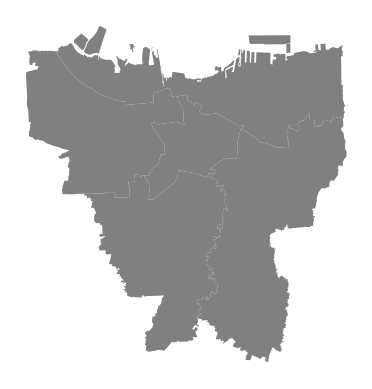

In [3]:
# get boundary polygons for Jakarta, save as GeoPackage, project to UTM, and plot
place_names = [
    "Jakarta Pusat, Jakarta, Indonesia",
    "Jakarta Selatan, Jakarta, Indonesia",
    "Jakarta Barat, Jakarta, Indonesia",
    "Jakarta Utara, Jakarta, Indonesia",
    "Jakarta Timur, Jakarta, Indonesia",
]
Jakarta = ox.geocode_to_gdf(place_names)
Jakarta.to_file("./Jakarta.gpkg", driver="GPKG")
Jakarta = ox.project_gdf(Jakarta)
Jakarta = ox.projection.project_gdf(Jakarta , to_crs='espg:4326', to_latlong=True)
ax = Jakarta.plot(fc="gray", ec="none")
_ = ax.axis("off")

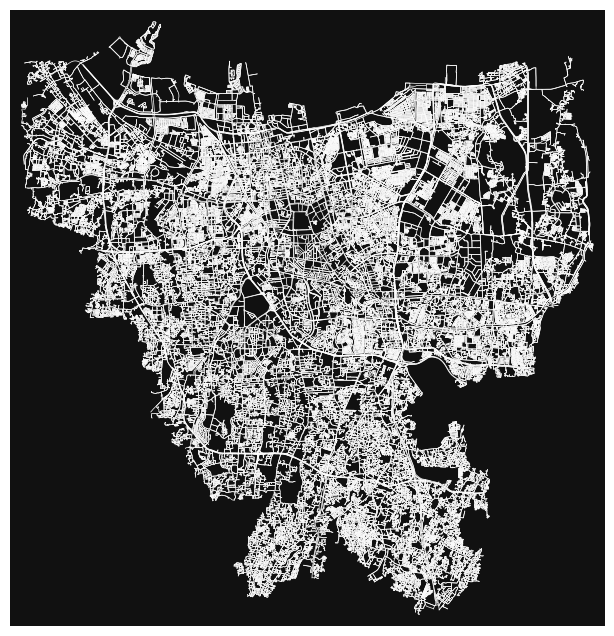

In [4]:

#get all transportation network
G2 = ox.graph_from_polygon(Jakarta.dissolve()['geometry'].iloc[0], network_type="drive")

ox.plot_graph(G2, node_size=0, edge_color="w", edge_linewidth=0.5);

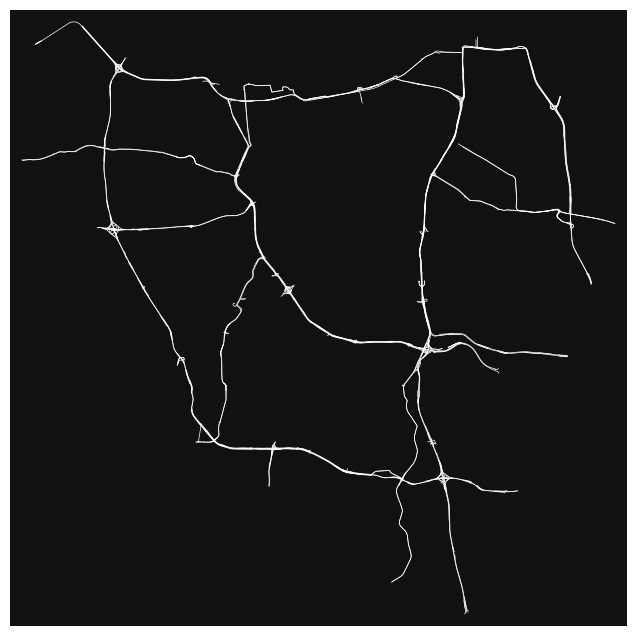

In [5]:
# highway network
G2_high = ox.graph_from_polygon(Jakarta.dissolve()['geometry'].iloc[0], custom_filter='["highway"~"motorway|motorway_link|trunk|trunk_link"]')
ox.plot_graph(G2_high, node_size=0, edge_color="w", edge_linewidth=0.5);

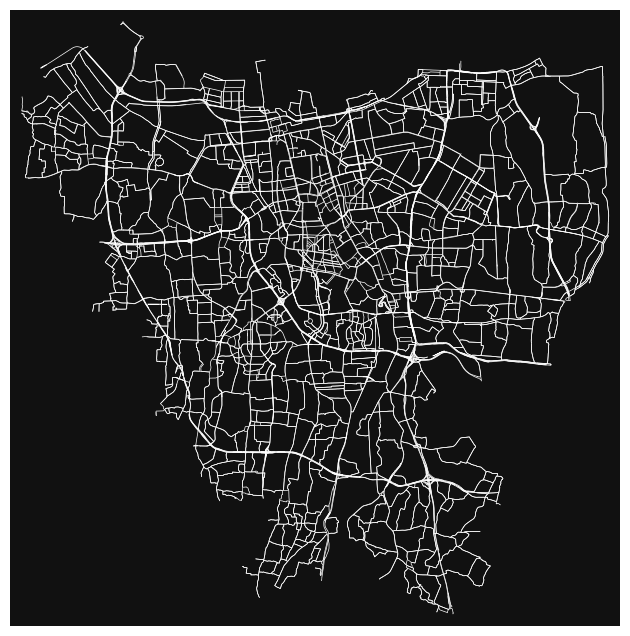

In [6]:
# primary road
G2_primary = ox.graph_from_polygon(Jakarta.dissolve()['geometry'].iloc[0], custom_filter='["highway"~"primary|motorway|motorway_link|trunk|trunk_link|primary_link|secondary|secondary_link|tertiary|tertiary_link"]')
G2_primary_copy = copy.deepcopy(G2_primary)
ox.plot_graph(G2_primary, node_size=0, edge_color="w", edge_linewidth=0.5);

In [7]:
# intersection number
print(f'all intersection : {len(G2)}')
print(f'highway: {len(G2_high)}')
print(f'primary roads: {len(G2_primary)}')

all intersection : 96564
highway: 1534
primary roads: 7972


# Data Processing

Why use G2_primary? 
less number of intersection and retain primary road in Jakarta

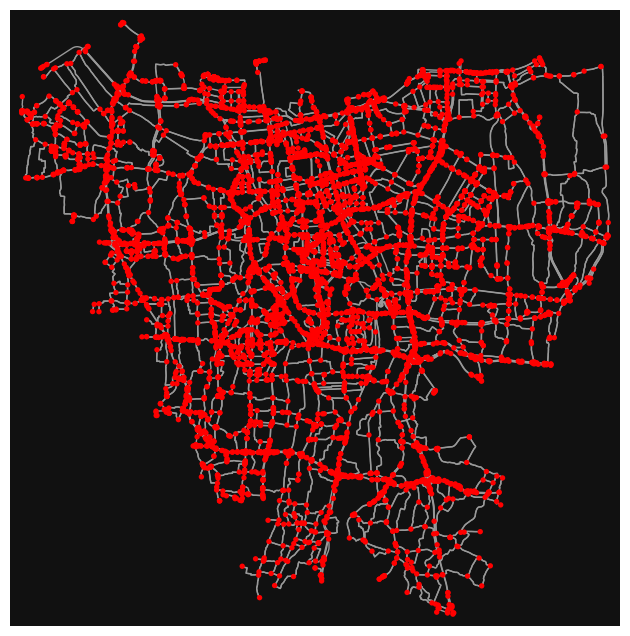

In [8]:
# highlight the intersections
fig, ax = ox.plot_graph(G2_primary, node_color="r")

position of intersection with highest degree (neighbouring street)

In [9]:
# the node degree distribution for this graph has many false cul-de-sacs
k = dict(G2_primary.degree())
connection_dict={n: list(k.values()).count(n) for n in range(max(k.values()) + 1)}

Text(0, 0.5, '#num of intersection')

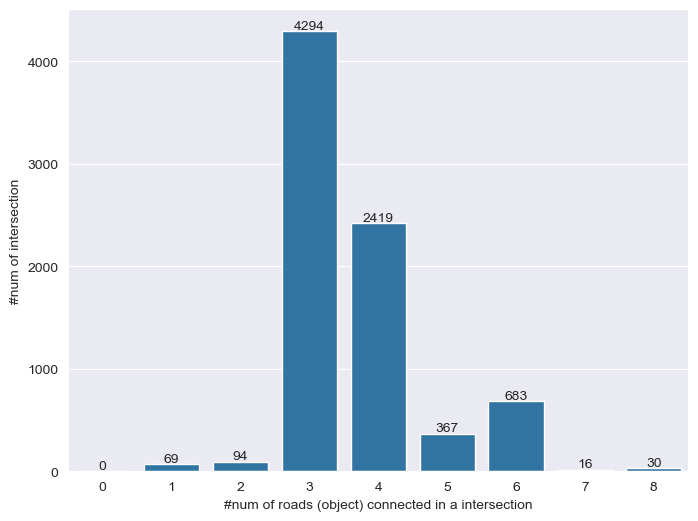

In [10]:

fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x=connection_dict.keys(),y=connection_dict.values(), ax=ax)

# show the mean
for intersection_num,streets_num in connection_dict.items():
    xy = (intersection_num, streets_num+50)
    text = f'{streets_num:0.0f}'
    ax.annotate(text=text, xy=xy, ha='center', va='center')
    
plt.xlabel('#num of roads (object) connected in a intersection')
plt.ylabel('#num of intersection')

get the most important intersection with betweenness centrality  

In [210]:
# calculate betweenness with a digraph of G (ie, no parallel edges)
bc = nx.betweenness_centrality(ox.get_digraph(G2_primary), weight="length")
max_node, max_bc = max(bc.items(), key=lambda x: x[1])
max_node, max_bc
print('max node info:')
print(G2_primary.nodes[max_node])

max node info:
{'y': -6.1832736, 'x': 106.8231695, 'highway': 'traffic_signals', 'street_count': 4}


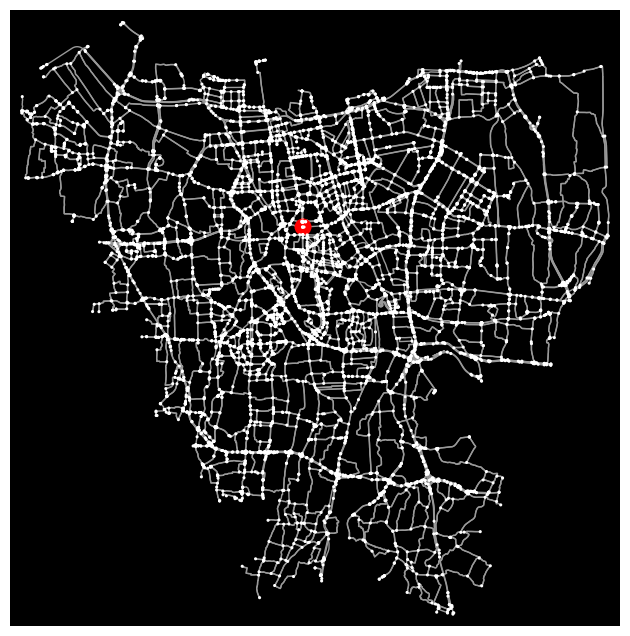

In [211]:
# plot the ost important intersection
nc = ["r" if node == max_node else "w" for node in G2_primary.nodes]
ns = [150 if node == max_node else 5 for node in G2_primary.nodes]
fig, ax = ox.plot_graph(G2_primary, node_size=ns, node_color=nc, node_zorder=2, bgcolor="k")

In [212]:
#structured bc as dict
bc = dict(sorted(bc.items(), key=lambda item: item[1],reverse=True))
bc

{4476152430: 0.08206305259325405,
 4488259486: 0.07722035666618972,
 1249723074: 0.07135433071609805,
 315480467: 0.0694013760987721,
 7225096520: 0.06940118720827239,
 104367971: 0.067883420561392,
 11076463250: 0.060013030296304656,
 104369586: 0.06001284140580495,
 5680696059: 0.059720092613012005,
 11395329908: 0.0597199037225123,
 11542695776: 0.05954116608716635,
 103292410: 0.058640142662698076,
 313442881: 0.05863995377219837,
 316395244: 0.05777623622142185,
 6768376574: 0.05656614071681111,
 315208899: 0.05653368303261178,
 5083992721: 0.056448225822370204,
 5668259581: 0.056360501926132164,
 124093345: 0.05554090604791176,
 313442871: 0.05430691589508833,
 313467363: 0.05430672700458862,
 315684305: 0.0539869983520878,
 5174097479: 0.053938532198038465,
 104363747: 0.05389647258010413,
 9002723306: 0.0538510129331751,
 4518625387: 0.05378140678403378,
 4518625492: 0.05378121789353407,
 316374658: 0.05377633822229169,
 315711023: 0.05367460494732552,
 316374654: 0.05362495822

In [240]:

def plot_top_n_intersection(bc,graph,number_of_intersection):
    #init dict
    top_20={'x'   :[],
            'y'   :[],
            'rank':[]}
    
    #sructured data as dict
    for i,key in enumerate(bc.keys(),start=1):
        top_20['rank'].append(i)
        top_20['x'].append(graph.nodes[key]['x'])
        top_20['y'].append(graph.nodes[key]['y'])
        if i == number_of_intersection:
            break

    #create a list of shapely Point objects from x and y coordinates
    geometry = [Point(xy) for xy in zip(top_20['x'], top_20['y'])]

    #create the GeoDataFrame
    gdf = gpd.GeoDataFrame(top_20, geometry=geometry)
    gdf.set_crs(epsg=4326, inplace=True)

    #plot the data
    my_map = gdf.sort_values(by='rank',ascending=False).explore(marker_kwds={'radius':10},
                popup='rank',
                column='rank',
                cmap='Spectral',)
    # folium.TileLayer('cartodbpositron').add_to(my_map)
    #plot the marker
    for idx, row in gdf.iterrows():
        folium.Marker(
            location=[row['y'], row['x']],  # Latitude, Longitude
            icon=folium.DivIcon(html=f"""<div style="font-size: 10px; color: black;">{row['rank']}</div>""")
        ).add_to(my_map)
        
    
    return my_map


In [241]:
plot_top_n_intersection(bc,G2_primary,50)

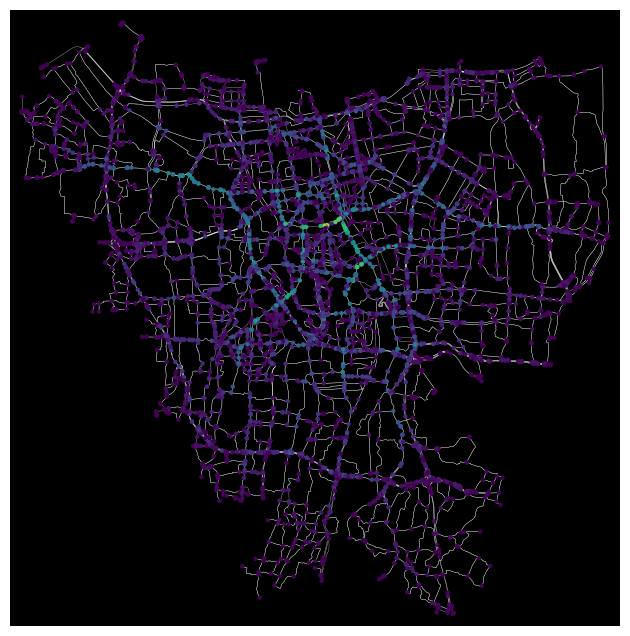

In [21]:
# add the betweenness centrality values as new node attributes, then plot
nx.set_node_attributes(G2_primary, bc, "bc")

#plot betweenness centrality value for all intersections
nc = ox.plot.get_node_colors_by_attr(G2_primary, "bc", cmap="viridis")
fig, ax = ox.plot_graph(
    G2_primary,
    node_color=nc,
    node_size=10,
    node_zorder=2,
    edge_linewidth=0.2,
    edge_color="w",
    bgcolor="k",
)

In [22]:
def get_hist_from_bc(bc,max,bin_num,xlabel,ylabel):

    # Extract values from the dictionary
    values = list(bc.values())

    # Define bin edges for the histogram (e.g., bins of size 10 from 0 to 50)
    bins = np.linspace(0,max,bin_num+1)  # Bins: [0-10, 10-20, 20-30, ...]

    # Calculate the histogram
    hist, bin_edges = np.histogram(values, bins=bins)

    fig, ax = plt.subplots(figsize=(8, 8))
    sns.barplot(y=bin_edges[1:],x=hist, ax=ax, orient="y")

    for i, value in enumerate(hist):
        plt.text(value + 200,         # x position: the value + padding
                i,                 # y position: the index of the item
                str(value),        # The annotation text (the value itself)
                ha='center',       # Horizontal alignment of the text
                va='bottom'
                )  
        
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

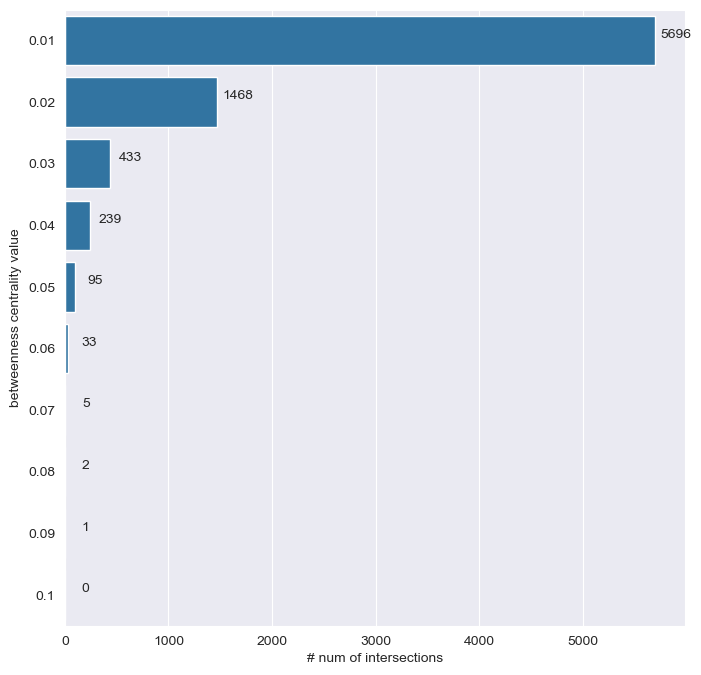

In [23]:
get_hist_from_bc(bc,0.1,10,'# num of intersections','betweenness centrality value')

Text(0, 0.5, 'betweenness centrality (%)')

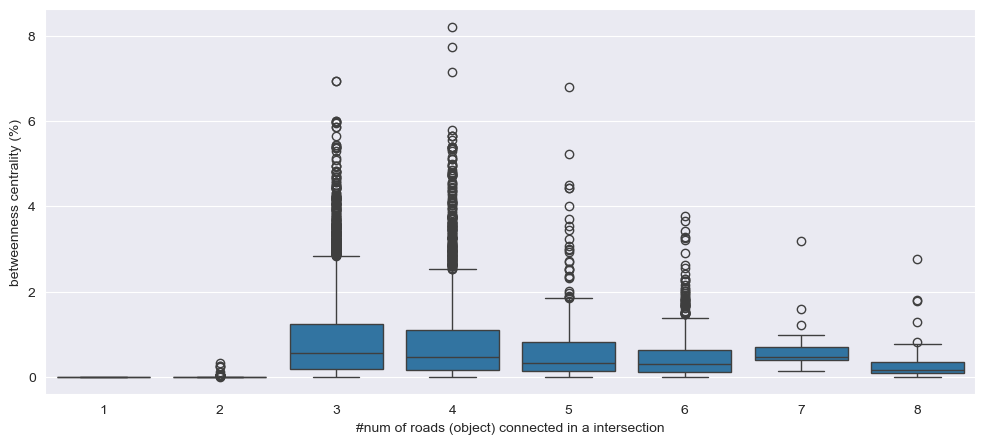

In [24]:
df_bc = pd.DataFrame.from_dict(data=bc, orient='index',columns=['bc']).reset_index()
df_degree = pd.DataFrame.from_dict(data=k, orient='index',columns=['degree']).reset_index()
df_merge = df_degree.merge(df_bc,on='index')
df_merge['bc'] = df_merge['bc']*100

plt.figure(figsize=(12,5))
sns.boxplot(df_merge,x='degree',y='bc')
plt.xlabel('#num of roads (object) connected in a intersection')
plt.ylabel('betweenness centrality (%)')

In [25]:
#checkpoint

with open('degree.pickle', 'wb') as handle:
    pickle.dump(k, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('betweenness_centrality.pickle', 'wb') as handle:
    pickle.dump(bc, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Treatment for stress test

In [26]:
def get_mean_of_shortest_dist(graph):
    shortest_paths = dict(nx.all_pairs_dijkstra_path_length(graph, weight='length'))

    # Extract all distances into a list
    all_distances = []
    for source, path_dict in shortest_paths.items():
        for target, distance in path_dict.items():
            # Avoid self-loops
            if source != target:
                all_distances.append(distance)

    # Calculate the mean of the shortest path distances
    if len(all_distances) > 0:
        mean_shortest_distance = sum(all_distances) / len(all_distances)
        return mean_shortest_distance
    else:
        print("No paths found")

In [60]:
random.seed(42)
def get_sample_mean_of_shortest_dist(graph, num_samples = 800):
    # Step 1: Sample a subset of nodes from the graph
    
    sampled_nodes = random.sample(graph.nodes(), num_samples,)

    # Step 2: Calculate shortest paths for each sampled node and gather distances
    all_distances = []

    for node in sampled_nodes:
        # Compute shortest paths from 'node' using Dijkstra's algorithm, considering 'length' as weight
        lengths = nx.single_source_dijkstra_path_length(graph, node, weight='length')
        
        # Collect distances (skip the distance from the node to itself, which is zero)
        distances = [length for target, length in lengths.items() if target != node]
        
        all_distances.extend(distances)

    # Step 3: Calculate the mean of the shortest distances
    #mean_distance = np.mean(all_distances)
    try:
        return np.random.choice(distances, num_samples, replace=False)
    except ValueError:
        return np.random.choice(distances, num_samples, replace=True)

In [62]:
def do_treatment(graph,number_of_iteration, stress_treatment):
    if stress_treatment == None:
        stress_treatment = {
            'node' : [],
            'mean_dist': [],
            'bc_values': []
        }

    for _ in range(number_of_iteration):
        # calculate betweenness with a digraph of G (ie, no parallel edges)
        bc_treatment = nx.betweenness_centrality(ox.get_digraph(graph), weight="length")
        max_node_treatment, max_bc_treatment = max(bc_treatment.items(), key=lambda x: x[1])
        
        stress_treatment['node'].append(max_node_treatment)
        stress_treatment['mean_dist'].append(get_sample_mean_of_shortest_dist(graph))
        
        stress_treatment['bc_values'].append(bc_treatment)
        if _%5 == 0 or _ == number_of_iteration-1:
            # print(stress_treatment['mean_dist'][-1])
            with open(f'degree_{_}.pickle', 'wb') as handle:
                pickle.dump(stress_treatment, handle, protocol=pickle.HIGHEST_PROTOCOL)
        graph.remove_node(max_node_treatment)
    return stress_treatment

In [64]:
number_of_iteration=45-26
stress_treatment = do_treatment(G2_primary_copy,number_of_iteration,stress_treatment)

with open('treatment.pickle', 'wb') as handle:
    pickle.dump(stress_treatment, handle, protocol=pickle.HIGHEST_PROTOCOL)

C:\Users\User\AppData\Local\Temp\ipykernel_23828\3463136586.py:11: FutureWarning: The `get_digraph` function is deprecated and will be removed in the v2.0.0 release. Replace it with `convert.to_digraph` instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  bc_treatment = nx.betweenness_centrality(ox.get_digraph(graph), weight="length")
C:\Users\User\AppData\Local\Temp\ipykernel_23828\4167048779.py:5: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sampled_nodes = random.sample(graph.nodes(), num_samples,)


In [9]:
with open('treatment.pickle', 'rb') as handle:
    stress_treatment = pickle.load(handle)

In [10]:
d_mean = []
for dist in stress_treatment['mean_dist']:
    d_mean.append(np.mean(dist))

In [203]:
import numpy as np
import matplotlib.pyplot as plt

def create_cdf(data_base):
    data_base_sorted = np.sort(data_base)

    cdf = np.arange(1, len(data_base_sorted) + 1) / len(data_base_sorted)
    
    return data_base_sorted, cdf

filenames =[]
for i in range(1,41):
    data_sorted_0, cdf_0 = create_cdf(stress_treatment['mean_dist'][0])
    data_sorted_c, cdf_c = create_cdf(stress_treatment['mean_dist'][i])
    _, p = stats.ks_2samp(stress_treatment['mean_dist'][0], stress_treatment['mean_dist'][i])
    if p > 0.05:
        print(f'same shape in treatment: {i}, p val: {p}')
    plt.plot(data_sorted_0, cdf_0, marker=".", label='No Treatment')
    plt.plot(data_sorted_c, cdf_c, marker="+", label=f'Treatment {i}',c='r')
    plt.xlabel("Shortest distance length in m")
    plt.ylabel("CDF")
    plt.title("Cumulative Distribution Function")
    plt.grid(True)
    plt.legend(loc='upper left')
    plt.text(10,0.8,f"KS p-value: {p:.2e}")
    plt.hlines(0.5,0,50_000,colors='r')
    plt.xlim(-0.1,50_000)
    # Save the plot as an image file
    filename = f'./plot/plot_{i}.png'
    plt.savefig(filename)
    filenames.append(filename)
    
    # Close the figure to free up memory
    plt.close()

same shape in treatment: 6, p val: 0.08785943060284065
same shape in treatment: 10, p val: 0.05969522811848217
same shape in treatment: 21, p val: 0.1419885147627293


In [147]:
import imageio
# Step 3: Create a GIF using imageio
with imageio.get_writer('distribution.mp4', mode='I', fps=3) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

Text(0, 0.5, 'Treatment')

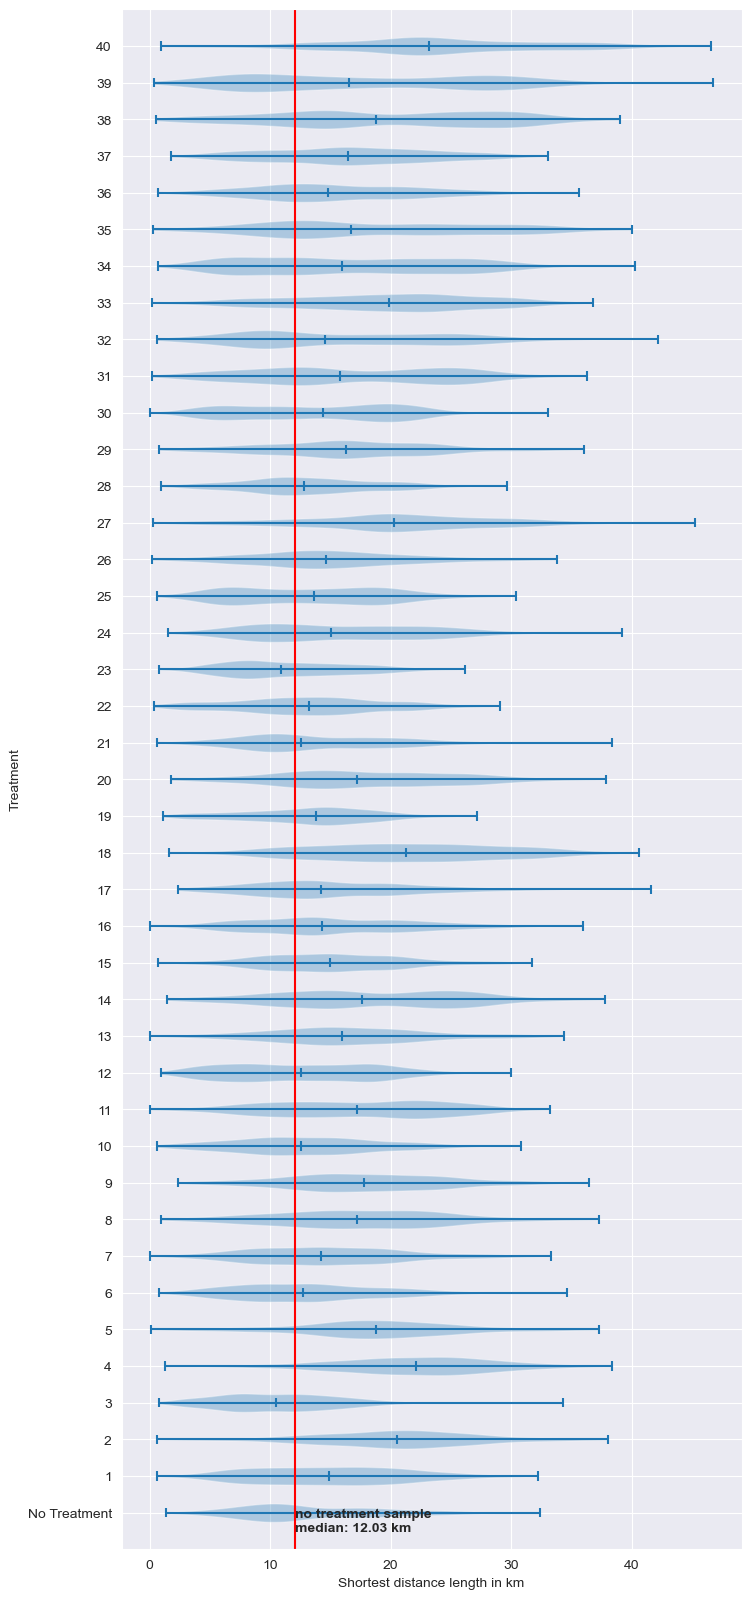

In [199]:
plt.figure(figsize=(8,20))
plt.violinplot([i/1_000 for i in stress_treatment['mean_dist'][:41]],
               showmeans=False,
               showmedians=True,
               vert=False)
plt.vlines(np.median(stress_treatment['mean_dist'][0]/1_000),0,42,colors='r')
plt.text(y=0.5,
         x=np.median(stress_treatment['mean_dist'][0]/1_000),
         s= f"no treatment sample \nmedian: {np.median(stress_treatment['mean_dist'][0]/1_000):.2f} km",
         weight='bold')
plt.ylim(0,42)
plt.yticks([y + 1 for y in range(41)],
           labels=['No Treatment']+[f'{i}' for i in range(1,41)], 
        #    rotation='vertical'
           )
plt.xlabel("Shortest distance length in km")
plt.ylabel("Treatment")

In [239]:
#init the dict
top_20={'x'   :[],
        'y'   :[],
        'rank':[]}

#iterate over the treatment result
for i,key in enumerate(stress_treatment['node'],start=0):
    top_20['rank'].append(i)
    top_20['x'].append(G2_primary.nodes[key]['x'])
    top_20['y'].append(G2_primary.nodes[key]['y'])
    if i == 40:
        break

#create a list of shapely Point objects from x and y coordinates
geometry = [Point(xy) for xy in zip(top_20['x'], top_20['y'])]

#create the GeoDataFrame
gdf = gpd.GeoDataFrame(top_20, geometry=geometry)
gdf.set_crs(epsg=4326, inplace=True)

my_map = gdf.explore(marker_kwds={'radius':9},
            style_kwds={'fill':True,
                        'fillOpacity':0.8
                },
            popup='rank',
            column='rank',   # Column to base the color gradient on
            cmap='summer', 
            )
folium.TileLayer('cartodbpositron').add_to(my_map)

for idx, row in gdf.iterrows():
    folium.Marker(
        location=[row['y'], row['x']],  # Latitude, Longitude
        icon=folium.DivIcon(html=f"""<div style="font-size: 10px; color: black;">{row['rank']}</div>""")
    ).add_to(my_map)
my_map

In [46]:
#get police data
#define a place or region to search (e.g., 'Manhattan, New York, USA')
place_name = ["Jakarta Selatan",
              "Jakarta Pusat",
              "Jakarta Barat",
              "Jakarta Timur",
              'Jakarta Utara'
              ]

#create the query to get police station locations using the `amenity=police` tag
tags = {'amenity': 'police'}

#use OSMnx to fetch geometries (police stations) within the area
gdf_police = ox.geometries_from_place(place_name, tags)

gdf_police['geometry'] = gdf_police.geometry.centroid

C:\Users\User\AppData\Local\Temp\ipykernel_4244\3455576902.py:14: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  gdf_police = ox.geometries_from_place(place_name, tags)
c:\Users\User\anaconda3\envs\geospatial_test\lib\site-packages\osmnx\features.py:294: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  polygon = gdf_place["geometry"].unary_union
C:\Users\User\AppData\Local\Temp\ipykernel_4244\3455576902.py:16: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_police['geometry'] = gdf_police.geometry.

In [47]:
# PLOT the important intersection locations and the police station proxymity

#create a base Folium map centered on the average location of both GeoDataFrames
m = folium.Map(location=[gdf.geometry.y.mean(), gdf.geometry.x.mean()], zoom_start=0)

#add the first GeoDataFrame to the map
folium_layer1 = gdf.explore(
            m=m,
            marker_kwds={'radius':5},
            style_kwds={'fill':True,
                        'fillOpacity':0.8
                },
            popup='rank',
            column='rank',   # Column to base the color gradient on
            cmap='jet', 
            )

#add the second GeoDataFrame to the same map
folium_layer2 = gdf_police.explore(
            m=m,
            column='name',
            tooltip="name",
            marker_type='circle',
            marker_kwds={'radius':500},
            style_kwds={'color':'black',
                        'fill':True,
                        'fillOpacity':0.1
                },
            legend=False
            )

#add layer control to toggle layers on/off
folium.LayerControl().add_to(m)

#save the map as an HTML file or display in Jupyter
m.save("overlay_map.html")  # Save to an HTML file

#plot
m


Get Processed Data

In [11]:
df_graph = pd.DataFrame.from_dict(dict(G2_primary.nodes(data=True)), orient='index')[['y','x','street_count']]
df_graph = df_graph.reset_index().rename(columns={'index': 'node','street_count':'n_street'})
df_graph

node         y           x  n_street
0        29938969 -6.180894  106.823052         3
1        29939005 -6.171432  106.823564         3
2        29939007 -6.171462  106.825529         3
3        29939013 -6.167436  106.825823         3
4        29939017 -6.168071  106.831593         3
...           ...       ...         ...       ...
7967  12201404945 -6.148358  106.909666         3
7968  12202798102 -6.200456  106.799344         3
7969  12205408601 -6.184670  106.729775         3
7970  12205409103 -6.184920  106.729843         3
7971  12205409104 -6.184843  106.730273         3

[7972 rows x 4 columns]

In [12]:
with open('treatment.pickle', 'rb') as handle:
    betweenness_centrality = pickle.load(handle)
df_bc = pd.DataFrame(data=betweenness_centrality).reset_index()

In [13]:
df_bc

index         node                                          mean_dist  \
0       0   4476152430  [4269.05, 22912.102000000003, 17211.4470000000...   
1       1   9002723306  [15167.444999999996, 17598.279, 2331.247000000...   
2       2    315480467  [22975.76, 22269.386, 16466.069999999996, 1486...   
3       3  10147935647  [14540.920000000002, 18443.524, 25848.92399999...   
4       4   5379949148  [20063.797000000006, 26795.062999999995, 18665...   
5       5    315198777  [28512.056999999997, 29074.21599999999, 19770....   
6       6   6380405825  [15337.421, 22312.035999999996, 8209.208999999...   
7       7    317988381  [15090.871, 12827.172999999999, 17511.07199999...   
8       8    316213895  [13146.249, 10571.003999999999, 14833.904, 202...   
9       9   4750115938  [5887.348, 8005.208, 11054.511, 31615.91499999...   
10     10    313442871  [25607.277000000002, 13676.133999999995, 8394....   
11     11   4642354382  [17768.458, 8432.147, 20500.383000000005, 1475...   
12     12    316395244  [21497.045000000006, 16450.873999999993, 13396...   
13     13    313315560  [21460.656, 24373.464999999997, 12580.819, 107...   
14     14    315208899  [19658.034, 13273.884000000004, 12190.573, 149...   
15     15    329878067  [3160.8610000000003, 21174.780000000006, 14988...   
16     16   4891131744  [14330.75, 19778.787, 8039.273000000003, 13489...   
17     17    315712497  [17382.951000000005, 10048.497999999998, 2415....   
18     18    315712057  [8487.055999999999, 38171.174999999996, 30253....   
19     19    328919697  [18055.524000000005, 12924.909000000001, 17623...   
20     20   5083992721  [11125.053999999998, 16238.059000000005, 16604...   
21     21    318569456  [11468.065000000002, 17489.488, 10049.268, 775...   
22     22   7117091534  [2322.289, 9924.132999999996, 13091.718, 13861...   
23     23   5463800064  [9397.436, 5095.23, 4247.779000000001, 12210.2...   
24     24    317190018  [11556.506, 33279.240999999995, 18207.47299999...   
25     25   7400356402  [11748.777999999998, 19082.839, 7471.009000000...   
26     26   1783134400  [254.42999999999998, 15567.126, 15317.31000000...   
27     27    352915237  [30495.694999999996, 39445.96000000001, 30871....   
28     28   4912030318  [6270.221, 14378.343, 20042.838000000003, 2174...   
29     29     95026274  [16484.149, 9944.621, 22911.452999999994, 1761...   
30     30   1783134368  [9013.526, 17968.767999999996, 15530.130999999...   
31     31   5493042864  [21426.222999999987, 23839.649000000005, 26853...   
32     32   5379751102  [15911.904999999999, 25661.26800000001, 28103....   
33     33    321763485  [5853.731000000001, 5099.5160000000005, 11645....   
34     34    346604689  [19493.96999999999, 14272.424999999997, 22642....   
35     35   4642465084  [11034.505999999998, 10453.042999999994, 3064....   
36     36   9039712071  [4865.236000000001, 15713.672999999993, 6771.9...   
37     37     95001908  [21184.399, 6699.092, 12562.460999999998, 2606...   
38     38    316736617  [11250.304999999998, 24753.528000000006, 19790...   
39     39   1757304311  [27734.746, 27816.316999999995, 33695.52400000...   
40     40    322399117  [21365.60199999999, 27282.85, 22605.4790000000...   
41     41   5377296249  [251.106, 953.945, 251.106, 251.106, 953.945, ...   
42     42  11021452026  [29944.84500000001, 19936.709000000003, 19695....   
43     43     94984987  [30008.01700000002, 27015.49400000002, 23718.4...   
44     44   4464981172  [14378.679000000004, 8564.856000000002, 5140.9...   

                                            bc_values  
0   {29938969: 0.01967708539440415, 29939005: 0.02...  
1   {29938969: 0.0031536098240153615, 29939005: 0....  
2   {29938969: 0.003335717068298291, 29939005: 0.0...  
3   {29938969: 0.004775204117587458, 29939005: 0.0...  
4   {29938969: 0.018064473270846308, 29939005: 0.0...  
5   {29938969: 0.020601728721832382, 29939005: 0.0...  
6   {29938969: 0.02152106008740525, 29939005: 0.04...  
7   {29938969

In [14]:
df_bc[df_bc['index'] == 0]['bc_values'].values[0]
for index,treatment in enumerate(betweenness_centrality['bc_values']):
    df_graph[f't_{index}'] = df_graph['node'].map(treatment)
    if index == 40:
        break

In [15]:
df_graph

node         y           x  n_street       t_0       t_1  \
0        29938969 -6.180894  106.823052         3  0.019677  0.003154   
1        29939005 -6.171432  106.823564         3  0.024915  0.015903   
2        29939007 -6.171462  106.825529         3  0.024915  0.015903   
3        29939013 -6.167436  106.825823         3  0.039143  0.030454   
4        29939017 -6.168071  106.831593         3  0.039363  0.030674   
...           ...       ...         ...       ...       ...       ...   
7967  12201404945 -6.148358  106.909666         3  0.002611  0.002611   
7968  12202798102 -6.200456  106.799344         3  0.035700  0.037306   
7969  12205408601 -6.184670  106.729775         3  0.002507  0.002507   
7970  12205409103 -6.184920  106.729843         3  0.003508  0.003508   
7971  12205409104 -6.184843  106.730273         3  0.002762  0.002762   

           t_2       t_3       t_4       t_5  ...      t_31      t_32  \
0     0.003336  0.004775  0.018064  0.020602  ...  0.041035  0.041291   
1     0.015534  0.019379  0.045014  0.044966  ...  0.050976  0.050966   
2     0.015534  0.019379  0.045014  0.044966  ...  0.050975  0.050965   
3     0.029322  0.032394  0.020417  0.020422  ...  0.050884  0.050793   
4     0.029543  0.032633  0.021921  0.022102  ...  0.051290  0.051184   
...        ...       ...       ...       ...  ...       ...       ...   
7967  0.002612  0.002612  0.002612  0.002612  ...  0.002782  0.002777   
7968  0.037388  0.037711  0.037524  0.037156  ...  0.044663  0.041906   
7969  0.002511  0.002511  0.002509  0.002509  ...  0.002508  0.002508   
7970  0.003524  0.003525  0.003523  0.003522  ...  0.003610  0.003626   
7971  0.002768  0.002769  0.002769  0.002768  ...  0.002805  0.002816   

          t_33      t_34      t_35      t_36      t_37      t_38      t_39  \
0     0.041344  0.041762  0.041772  0.042078  0.042604  0.042632  0.043569   
1     0.051113  0.051041  0.051053  0.051237  0.051199  0.051181  0.051516   
2     0.051113  0.051040  0.051053  0.051236  0.051199  0.051180  0.051516   
3     0.050941  0.050882  0.050895  0.051091  0.051079  0.051039  0.051397   
4     0.051333  0.051272  0.051284  0.051541  0.051537  0.051491  0.051881   
...        ...       ...       ...       ...       ...       ...       ...   
7967  0.002778  0.002777  0.002777  0.002777  0.002778  0.002777  0.002777   
7968  0.042095  0.038009  0.038309  0.038325  0.033418  0.032811  0.031955   
7969  0.002508  0.002508  0.002503  0.002505  0.002504  0.002503  0.002503   
7970  0.003624  0.003645  0.003635  0.003637  0.003654  0.003655  0.003653   
7971  0.002814  0.002803  0.002812  0.002812  0.002843  0.002845  0.002845   

          t_40  
0     0.043435  
1     0.051394  
2     0.051393  
3     0.051273  
4     0.051758  
...        ...  
7967  0.002778  
7968  0.032077  
7969  0.002503  
7970  0.003649  
7971  0.002841  

[7972 rows x 45 columns]

In [16]:
# Convert the latitude and longitude into a geometry column (points)
geometry = [Point(xy) for xy in zip(df_graph['x'], df_graph['y'])]

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(df_graph, geometry=geometry)
gdf.set_crs(epsg=4326, inplace=True)
gdf.head(2)

gdf.to_file('./assets/graph_data_1.shp')

# aux data

In [18]:

#use OSMnx to fetch geometries (police stations) within the area
gdf_police = ox.geometries_from_place(place_names, tags= {'amenity': 'police'})

gdf_police['geometry'] = gdf_police.geometry.centroid

gdf_police = gdf_police[gdf_police['name'].notna() | gdf_police['operator'].notna()]
gdf_police.reset_index()[['geometry','name','name:en','addr:full','operator']].to_file('./assets/police.shp')

C:\Users\User\AppData\Local\Temp\ipykernel_25752\3703506774.py:2: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  gdf_police = ox.geometries_from_place(place_names, tags= {'amenity': 'police'})
C:\Users\User\AppData\Local\Temp\ipykernel_25752\3703506774.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_police['geometry'] = gdf_police.geometry.centroid
c:\Users\User\anaconda3\envs\geospatial_test\lib\site-packages\pyogrio\raw.py:709: RuntimeWarning: Normalized/laundered field name: 'name:en' to 'name_en'
  ogr_write(
c:\Users\User\anaconda3\envs\geo

In [20]:
fire_stations = ox.geometries_from_place(place_names, tags={'amenity': 'fire_station'})
fire_stations['geometry'] = fire_stations.geometry.centroid
fire_stations.reset_index()[['geometry','name','name:en','addr:full','operator']].to_file('./assets/fire_station.shp')

C:\Users\User\AppData\Local\Temp\ipykernel_25752\1840487679.py:1: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  fire_stations = ox.geometries_from_place(place_names, tags={'amenity': 'fire_station'})
c:\Users\User\anaconda3\envs\geospatial_test\lib\site-packages\osmnx\features.py:294: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  polygon = gdf_place["geometry"].unary_union
C:\Users\User\AppData\Local\Temp\ipykernel_25752\1840487679.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fire_stations

In [21]:
fire_stations['geometry']

element_type  osmid      
node          6219136087     POINT (106.83846 -6.19063)
              6284647287     POINT (106.79437 -6.15144)
              6335494714     POINT (106.88191 -6.10875)
              8486041419     POINT (106.81153 -6.31551)
              11779972199     POINT (106.87141 -6.2775)
                                        ...            
way           526082873      POINT (106.83782 -6.28429)
              526636565      POINT (106.92675 -6.10075)
              527222729      POINT (106.81766 -6.12376)
              527796416      POINT (106.96169 -6.09962)
              1268372711     POINT (106.92601 -6.24747)
Name: geometry, Length: 96, dtype: geometry

In [22]:
def get_proximity(gdf,
                  gdf_reference,
                  buffer=500, 
                  n=100,
                  sort_by='treatment'
                  ):
    gdf1 = gdf_reference.to_crs(epsg=3857)  # Project to Mercator (meters)
    gdf2 = gdf.to_crs(epsg=3857)  # Project to Mercator (meters)

    gdf1_buffer = gdf1.copy()
    gdf1_buffer['geometry'] = gdf1.geometry.buffer(buffer)  
    
    gdf2['within_500m'] = gdf2.geometry.apply(lambda x: gdf1_buffer.geometry.contains(x).any())

    prox = []
    for i in range(41):
        if sort_by == 'treatment':
            prox.append(gdf2.sort_values(by=f't_{i}',ascending=False).head(n)['within_500m'].sum())
        else:
            prox.append(gdf2['within_500m'].sum())
    return prox,gdf2

In [24]:
prox_police,gdf2 = get_proximity(gdf,gdf_police,buffer = 500,n=100,sort_by='treatment')
prox_fire,gdf2 = get_proximity(gdf,fire_stations,buffer = 500,n=100,sort_by='treatment')

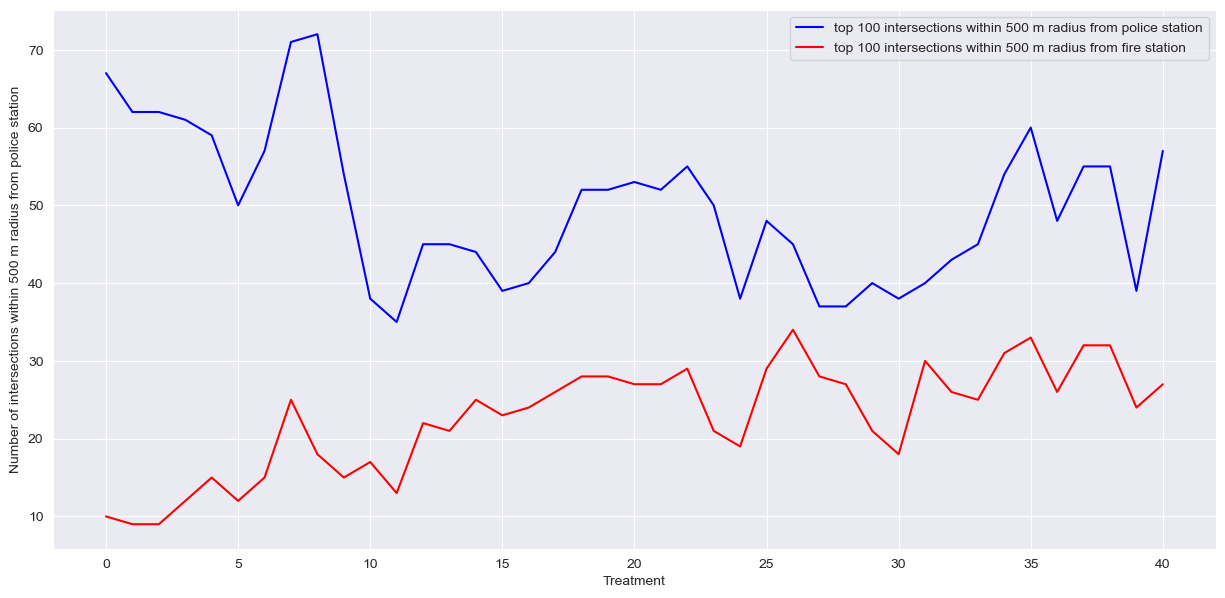

In [25]:
plt.figure(figsize=(15,7))
plt.plot(prox_police, c='b', label='top 100 intersections within 500 m radius from police station')
plt.plot(prox_fire  , c='r', label='top 100 intersections within 500 m radius from fire station')
plt.xlabel('Treatment')
plt.ylabel('Number of intersections within 500 m radius from police station')
plt.legend()

In [26]:
#init the dict
top_20={'x'   :[],
        'y'   :[],
        'rank':[]}

#iterate over the treatment result
for i,key in enumerate(stress_treatment['node'],start=0):
    top_20['rank'].append(i)
    top_20['x'].append(G2_primary.nodes[key]['x'])
    top_20['y'].append(G2_primary.nodes[key]['y'])
    if i == 40:
        break

#create a list of shapely Point objects from x and y coordinates
geometry = [Point(xy) for xy in zip(top_20['x'], top_20['y'])]

#create the GeoDataFrame
gdf = gpd.GeoDataFrame(top_20, geometry=geometry)
gdf.set_crs(epsg=4326, inplace=True)


x         y  rank                    geometry
0   106.823170 -6.183274     0  POINT (106.82317 -6.18327)
1   106.820692 -6.167661     1  POINT (106.82069 -6.16766)
2   106.834859 -6.182309     2  POINT (106.83486 -6.18231)
3   106.820976 -6.167709     3  POINT (106.82098 -6.16771)
4   106.851857 -6.201012     4  POINT (106.85186 -6.20101)
5   106.849813 -6.195363     5  POINT (106.84981 -6.19536)
6   106.830193 -6.173516     6  POINT (106.83019 -6.17352)
7   106.810354 -6.165609     7  POINT (106.81035 -6.16561)
8   106.844048 -6.184859     8  POINT (106.84405 -6.18486)
9   106.846291 -6.188309     9  POINT (106.84629 -6.18831)
10  106.848919 -6.207878    10  POINT (106.84892 -6.20788)
11  106.817694 -6.154417    11  POINT (106.81769 -6.15442)
12  106.878810 -6.166283    12  POINT (106.87881 -6.16628)
13  106.833969 -6.205159    13  POINT (106.83397 -6.20516)
14  106.875148 -6.192448    14  POINT (106.87515 -6.19245)
15  106.874038 -6.196988    15  POINT (106.87404 -6.19699)
16  106.822308 -6.171224    16  POINT (106.82231 -6.17122)
17  106.834396 -6.145560    17   POINT (106.8344 -6.14556)
18  106.834601 -6.148732    18   POINT (106.8346 -6.14873)
19  106.857869 -6.190529    19  POINT (106.85787 -6.19053)
20  106.827519 -6.236682    20  POINT (106.82752 -6.23668)
21  106.810575 -6.160813    21  POINT (106.81057 -6.16081)
22  106.813767 -6.138510    22  POINT (106.81377 -6.13851)
23  106.861495 -6.213688    23   POINT (106.8615 -6.21369)
24  106.862741 -6.225083    24  POINT (106.86274 -6.22508)
25  106.877697 -6.240009    25   POINT (106.8777 -6.24001)
26  106.843569 -6.242775    26  POINT (106.84357 -6.24278)
27  106.867390 -6.231888    27  POINT (106.86739 -6.23189)
28  106.854940 -6.216724    28  POINT (106.85494 -6.21672)
29  106.847553 -6.243221    29  POINT (106.84755 -6.24322)
30  106.840600 -6.242230    30   POINT (106.8406 -6.24223)
31  106.869105 -6.242224    31   POINT (106.8691 -6.24222)
32  106.828821 -6.130207    32  POINT (106.82882 -6.13021)
33  106.862136 -6.242924    33  POINT (106.86214 -6.24292)
34  106.793209 -6.137096    34   POINT (106.79321 -6.1371)
35  106.806721 -6.141800    35   POINT (106.80672 -6.1418)
36  106.863729 -6.258004    36    POINT (106.86373 -6.258)
37  106.843770 -6.303437    37  POINT (106.84377 -6.30344)
38  106.807934 -6.135019    38  POINT (106.80793 -6.13502)
39  106.821237 -6.131725    39  POINT (106.82124 -6.13172)
40  106.791978 -6.126817    40  POINT (106.79198 -6.12682)

[np.int64(7), np.int64(7), np.int64(7), np.int64(7), np.int64(7), np.int64(7), np.int64(7), np.int64(7), np.int64(7), np.int64(7), np.int64(7), np.int64(7), np.int64(7), np.int64(7), np.int64(7), np.int64(7), np.int64(7), np.int64(7), np.int64(7), np.int64(7), np.int64(7), np.int64(7), np.int64(7), np.int64(7), np.int64(7), np.int64(7), np.int64(7), np.int64(7), np.int64(7), np.int64(7), np.int64(7), np.int64(7), np.int64(7), np.int64(7), np.int64(7), np.int64(7), np.int64(7), np.int64(7), np.int64(7), np.int64(7), np.int64(7)]


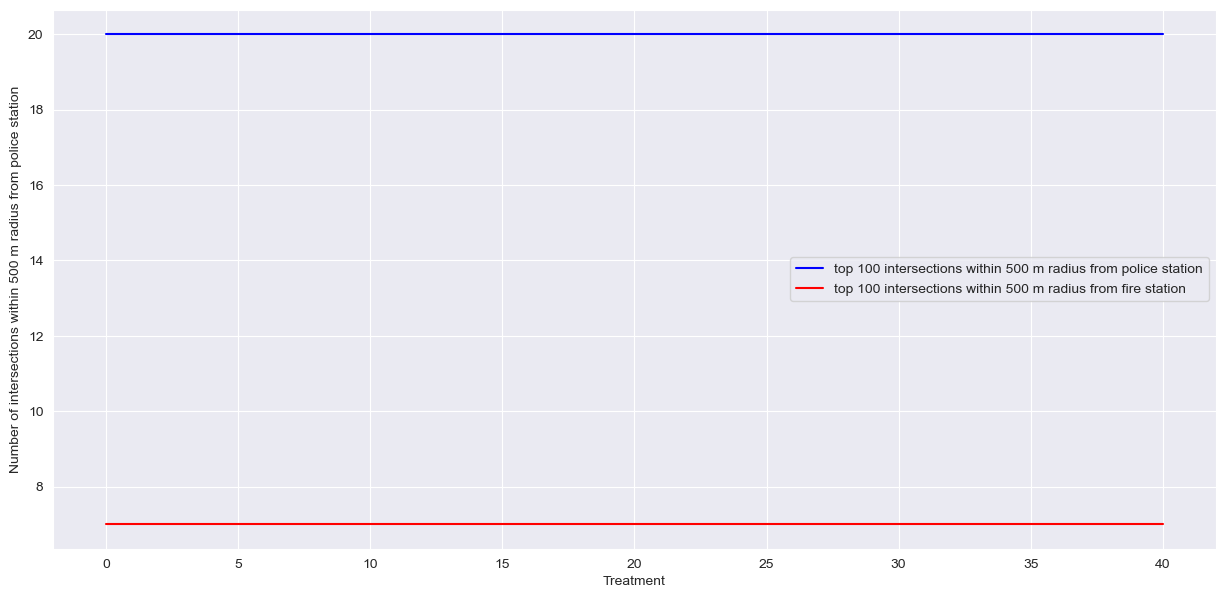

In [30]:
prox_police,gdf2 = get_proximity(gdf,gdf_police,buffer = 500,n=40, sort_by=None)
prox_fire,gdf2 = get_proximity(gdf,fire_stations,buffer = 500,n=40, sort_by=None)
print(prox_fire)
plt.figure(figsize=(15,7))
plt.plot(prox_police, c='b', label='top 100 intersections within 500 m radius from police station')
plt.plot(prox_fire  , c='r', label='top 100 intersections within 500 m radius from fire station')
plt.xlabel('Treatment')
plt.ylabel('Number of intersections within 500 m radius from police station')
plt.legend()

In [330]:
# PLOT the important intersection locations and the police station proxymity

#create a base Folium map centered on the average location of both GeoDataFrames
m = folium.Map(location=[gdf.geometry.y.mean(), gdf.geometry.x.mean()], zoom_start=0)

#add the first GeoDataFrame to the map
folium_layer1 = gdf.explore(
            m=m,
            marker_kwds={'radius':5},
            style_kwds={'fill':True,
                        'fillOpacity':0.8
                },
            popup='rank',
            column='rank',   # Column to base the color gradient on
            cmap='winter', 
            )

#add the second GeoDataFrame to the same map
folium_layer2 = fire_stations.explore(
            m=m,
            column='name',
            tooltip="name",
            marker_type='circle',
            marker_kwds={'radius':500},
            style_kwds={'color':'red',
                        'fill':True,
                        'fillOpacity':0.1
                },
            legend=False
            )

#add layer control to toggle layers on/off
folium.LayerControl().add_to(m)

#save the map as an HTML file or display in Jupyter
m.save("overlay_map.html")  # Save to an HTML file

#plot
m


In [331]:
# PLOT the important intersection locations and the police station proxymity

#create a base Folium map centered on the average location of both GeoDataFrames
m = folium.Map(location=[gdf.geometry.y.mean(), gdf.geometry.x.mean()], zoom_start=0)

#add the first GeoDataFrame to the map
folium_layer1 = gdf.explore(
            m=m,
            marker_kwds={'radius':5},
            style_kwds={'fill':True,
                        'fillOpacity':0.8
                },
            popup='rank',
            column='rank',   # Column to base the color gradient on
            cmap='winter', 
            )

#add the second GeoDataFrame to the same map
folium_layer2 = gdf_police.explore(
            m=m,
            column='name',
            tooltip="name",
            marker_type='circle',
            marker_kwds={'radius':500},
            style_kwds={'color':'black',
                        'fill':True,
                        'fillOpacity':0.1
                },
            legend=False
            )

#add layer control to toggle layers on/off
folium.LayerControl().add_to(m)

#save the map as an HTML file or display in Jupyter
m.save("overlay_map.html")  # Save to an HTML file

#plot
m


In [34]:
def count_proximity(gdf,
                  gdf_reference,
                  treatment,
                  n=100,
                  buffer=500, 
                  ):
    gdf1 = gdf_reference.to_crs(epsg=3857)  # Project to Mercator (meters)
    gdf2 = gdf.to_crs(epsg=3857)  # Project to Mercator (meters)

    gdf1_buffer = gdf1.copy()
    gdf1_buffer['geometry'] = gdf1.geometry.buffer(buffer)  
    
    gdf2['within_500m'] = gdf2.geometry.apply(lambda x: gdf1_buffer.geometry.contains(x).any())

    prox = gdf2.sort_values(by=f't_{treatment}',ascending=False).head(n)['within_500m'].sum()

    return prox

df_dummy =gpd.read_file('./assets/graph_data_1.shp')
count_proximity(df_dummy,fire_stations,30)

np.int64(18)